# NJIT Fall 2024 CS634: Data Mining Final Project #
## Joshua Kobuskie ##
### November 17, 2024 ###

##### Supervised Data Mining (Classification) Binary Classification Only #####

*Implement 3 different classification algorithms in Python. One of them is Random Forest, the second one is from the deep learning list in the “Appendix → Additional Option: Deep Learning”, and the third is from the list of algorithms in “Appendix → Additional Option: Algorithms” on 1 dataset of your choice (each of the three algorithms must run on the same dataset).*

*NOTE: This is not from scratch implementation, just use the existing libraries to implement the algorithms, but the performance metrics must be calculated manually. You may use “confusion_matrix” library to get TP, TN, FP, FN ONLY, then calculate the FPR, FNR, etc.… using the formulas from the slides.*

*Sources of data are listed in the Appendix “Additional Option: Sources of Data” or use your own.*

*Your final term project documentation must clearly indicate the algorithms and dataset you used in the project.*  
The classification algorithms that I have chosen to implement and evaluate in this project are the Random Forest Classifier, the Convolutional 1D network, and the naive Bayes algorithm.  
The dataset I have chosen to use in this project is KDDCup99 dataset from the Scikit-learn real world datasets. This dataset contains TCP network connection data with about 5 million training records and 2 million test records. Each record is labelled as normal, or as a specific attack type. To ensure that this data will meet the criteria for binary classification used in this project, the data will be separated into 2 classes of either normal or attack, rather than the specific classes of attacks detailed within the dataset. This also models the intention of the dataset by prioritizing attack detection rather than attack type identification. This is evident as the training data contains 24 types of attack, but the test data contains an additional 14 types of attacks not previously seen in the training data. By attempting to identify attacks rather than attack types, this will test the models' ability to detect known, and unknown attacks based on their understanding of normal network data. The models I will implement will be able to classify records as either normal TCP network connection data or abnormal TCP network connection data indicative of an attack.

*In addition to the general submission rules and grading, include the websites where the software and complete dataset can be downloaded.*  
The Scikit-learn software can be downloaded at the following link: https://scikit-learn.org/stable/install.html  
The KDDCup99 dataset can be downloaded in its entirety at the following link: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

The KDDCup99 dataset is first imported from Scikit-learn and inspected

In [18]:
from sklearn.datasets import fetch_kddcup99
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dataset = fetch_kddcup99(as_frame=True).frame
print(dataset["labels"].value_counts())
print(dataset.info())

labels
b'smurf.'              280790
b'neptune.'            107201
b'normal.'              97278
b'back.'                 2203
b'satan.'                1589
b'ipsweep.'              1247
b'portsweep.'            1040
b'warezclient.'          1020
b'teardrop.'              979
b'pod.'                   264
b'nmap.'                  231
b'guess_passwd.'           53
b'buffer_overflow.'        30
b'land.'                   21
b'warezmaster.'            20
b'imap.'                   12
b'rootkit.'                10
b'loadmodule.'              9
b'ftp_write.'               8
b'multihop.'                7
b'phf.'                     4
b'perl.'                    3
b'spy.'                     2
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   duration                     494021 non-null 

All values in the dataset are currently stored as objects and will be converted into integers, floats, or strings based on the appropriate datatype for easier processing.

In [2]:
for col in dataset.columns:
    try:
        dataset[col] = pd.to_numeric(dataset[col])
    except:
        dataset[col] = dataset[col].apply(lambda x: x.decode("utf-8"))
        dataset[col] = dataset[col].astype("string")

print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  string 
 2   service                      494021 non-null  string 
 3   flag                         494021 non-null  string 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

This dataset contains all the data needed for classification, but currently stores the protocol_type, service, flag, and labels as strings. These values will be one-hot encoded rather than being preserved as categorical variables to prevent ordinal implications in the models. This data also presents a multi-classification problem rather than a binary classification. To transform this into a binary classification problem, I will use two class labels of normal and attack and convert the current dataset labels accordingly. All non-normal labels will be considered an attack for training and testing purposes.

In [19]:
def transformLabel(col):
    if col == "normal.":
        return 0
    else:
        return 1

#1-hot encode
dataset = pd.get_dummies(dataset, columns = ["protocol_type", "service", "flag"])

#Normal will be 0, attack will be 1
labelDict = {"normal":0, 0: "normal", "attack":1, 1:"attack"}
dataset["labels"] = dataset["labels"].apply(transformLabel)

#Sort data for stratified results later
dataset = dataset.sort_values(by=["labels"], ignore_index=True)

#Save index of starting 1
attackIndex = dataset.index[dataset.labels == 1][0]

print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Columns: 119 entries, duration to flag_b'SH'
dtypes: bool(80), int64(1), object(38)
memory usage: 184.7+ MB
None


Now that the data has been transformed, I prepare this dataset for training by separating the X dimensions and the Y labels.

In [4]:
xdf = dataset.loc[:, dataset.columns != "labels"]
ydf = dataset.loc[:, "labels"]
print(xdf.info())
print(ydf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Columns: 118 entries, duration to flag_SH
dtypes: boolean(80), float64(15), int64(23)
memory usage: 218.6 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 494021 entries, 0 to 494020
Series name: labels
Non-Null Count   Dtype
--------------   -----
494021 non-null  int64
dtypes: int64(1)
memory usage: 3.8 MB
None


In the KDDCup99 dataset, there is an imbalance in the number of normal connections and attack connections with a bias toward attack connection data. This bias is visualized below.

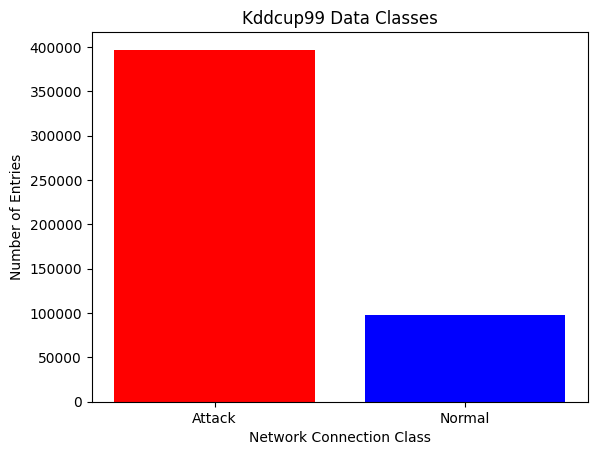

#################### Checking for Data Imbalance ####################
Attack Entries: 396743, Normal Entries: 97278, Total Entries: 494021
Attack Entries: 80.31%, Normal Entries: 19.69%


In [5]:
plt.bar(["Attack", "Normal"], ydf.value_counts(), color=["red", "blue"])
plt.xlabel("Network Connection Class")
plt.ylabel("Number of Entries")
plt.title("Kddcup99 Data Classes")
plt.show()
print("#################### Checking for Data Imbalance ####################")
print("Attack Entries: {}, Normal Entries: {}, Total Entries: {}".format(ydf.value_counts()[1], ydf.value_counts()[0], ydf.count()))
print("Attack Entries: {:.2f}%, Normal Entries: {:.2f}%".format(ydf.value_counts()[1] / ydf.count() * 100, ydf.value_counts()[0] / ydf.count() * 100))

To overcome this imbalance in data, either the normal data could be over-sampled or the attack data could be under-sampled. While these options would balance the dataset, the data mining techniques used in this project are able to effectively work with small imbalances in data and neither of these approaches are necessary to achieve high model performance. In the real world, it is likely that an imbalance in the data would exist as well, and thus the small imbalance has been disregarded.  
To ensure that the classes are proportionally utilized during training and testing, a stratified sampling approach will be used during the k-fold cross validation.

To visualize the correlation of the variables, a correlation matrix is used. This will help to identify data for dimensional reduction.

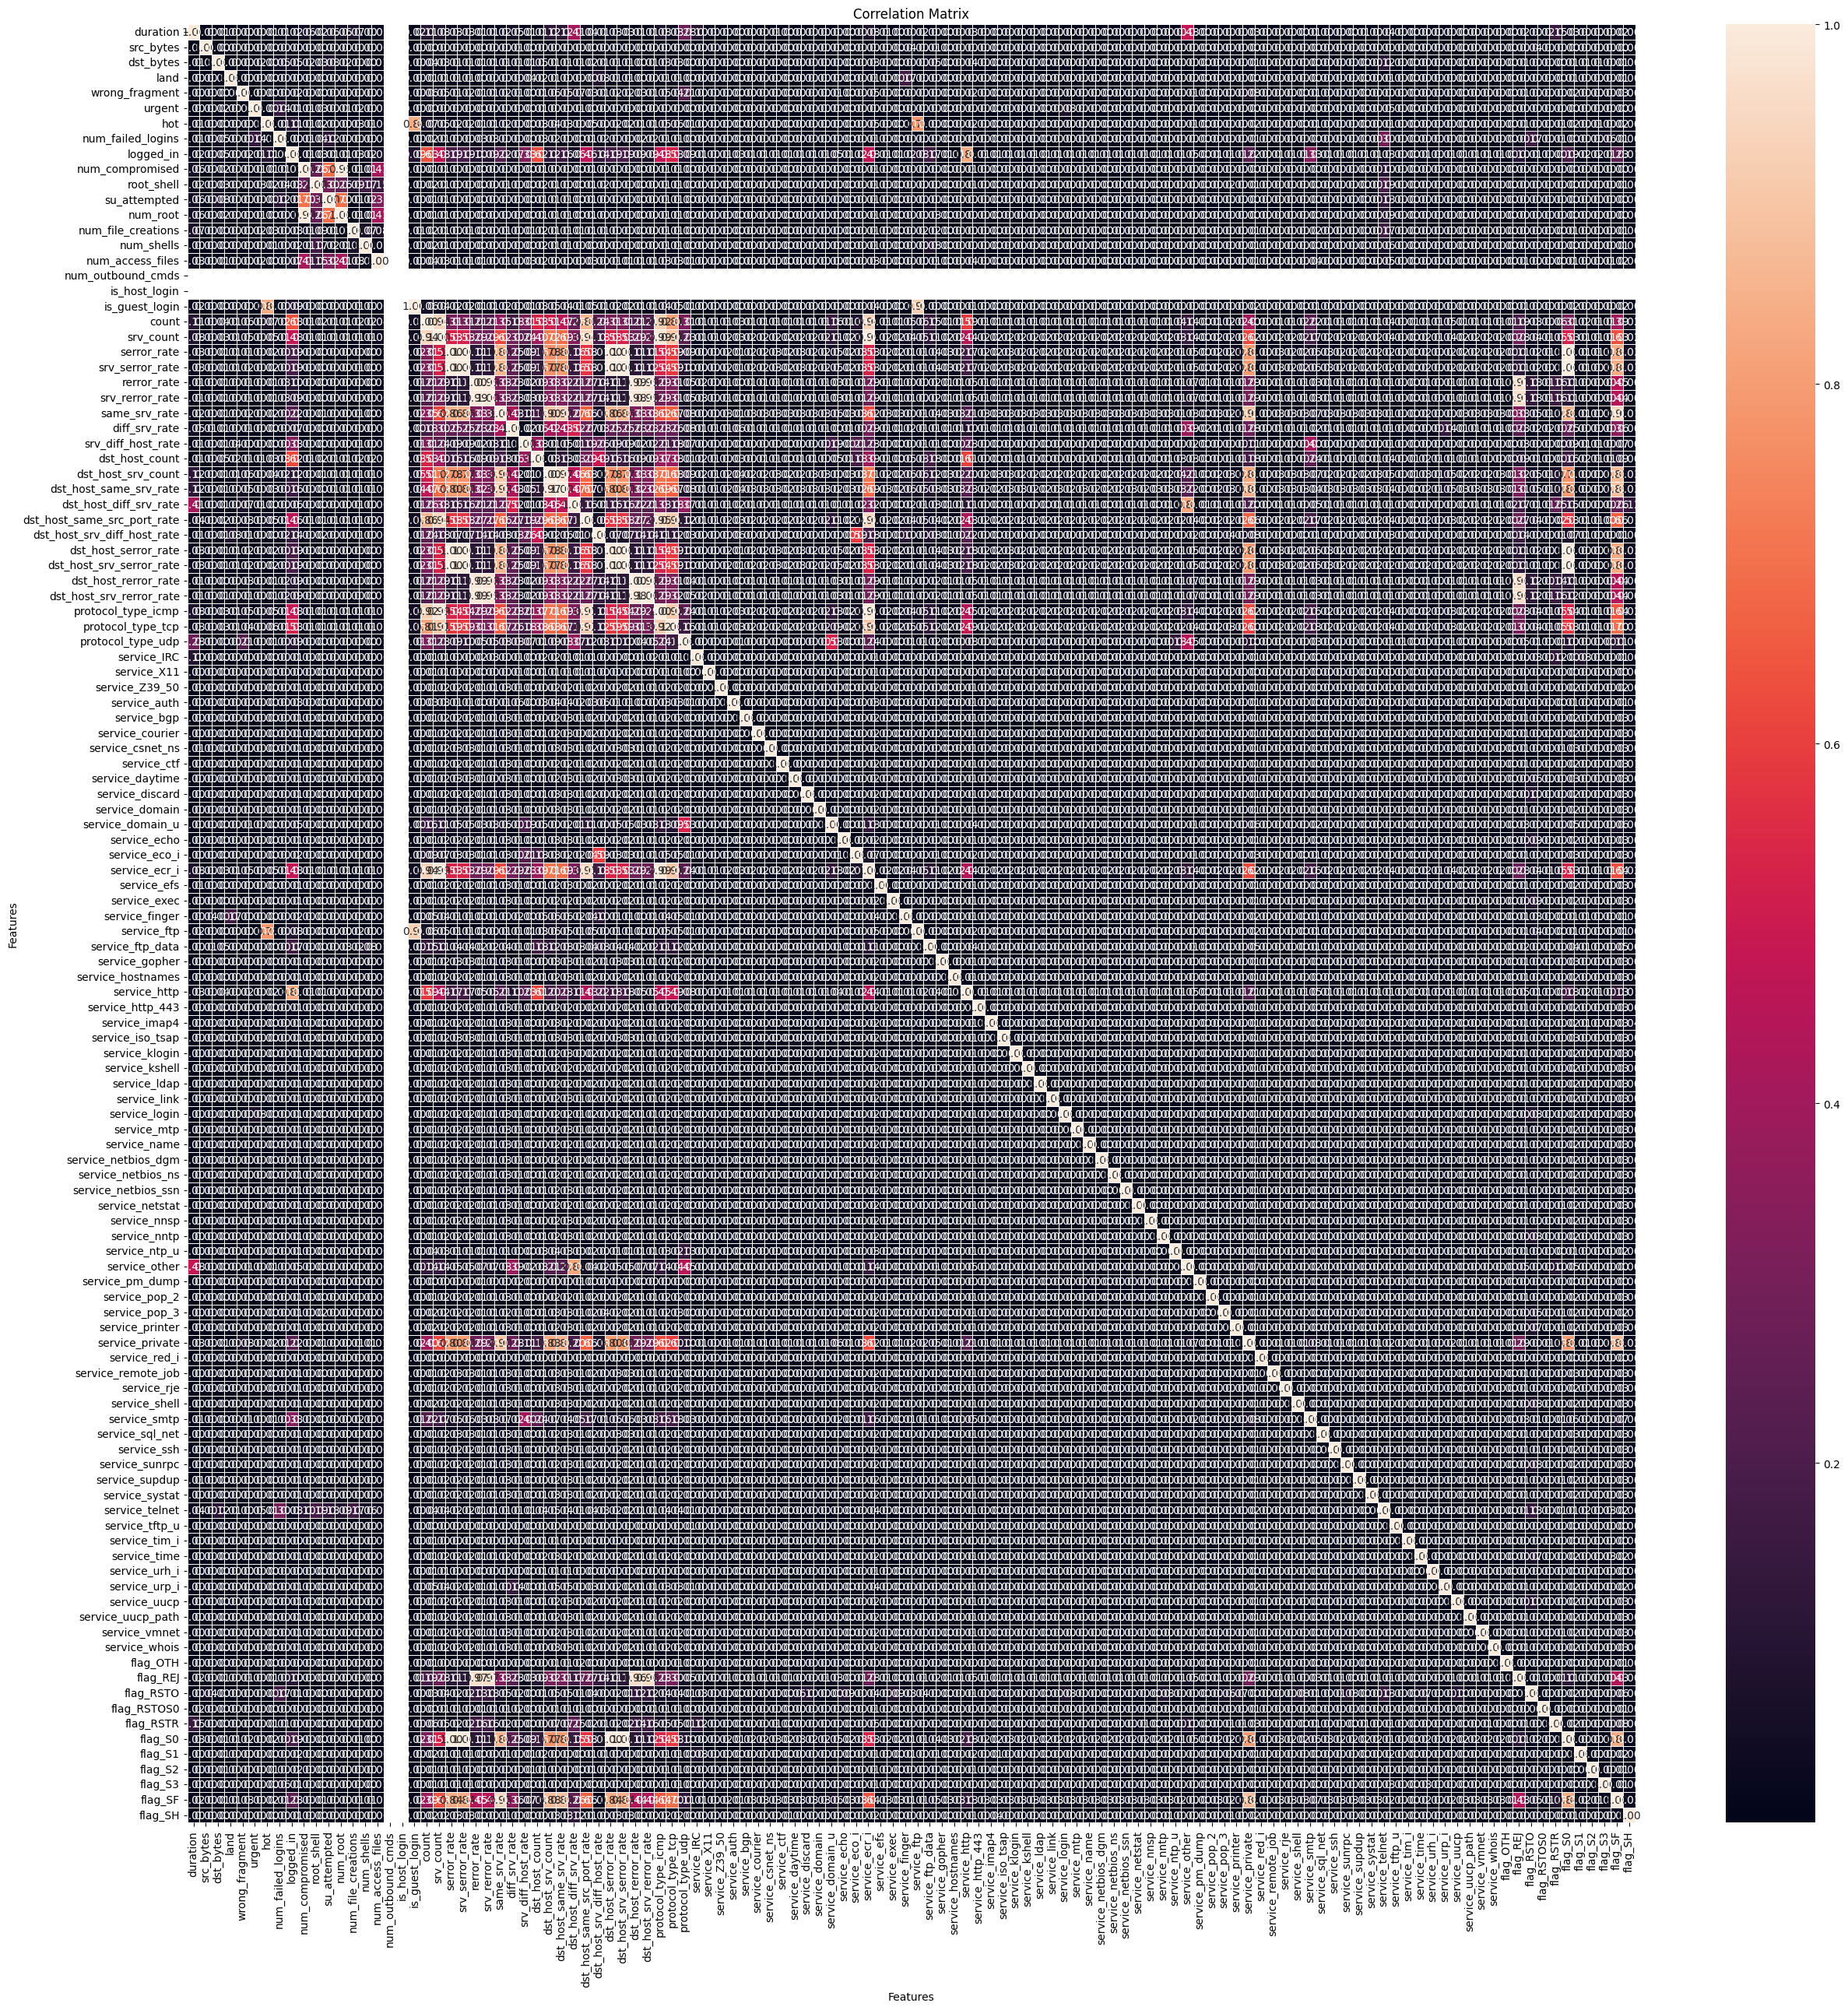

In [6]:
#create and display correlation matrix
corrMat = xdf.corr().abs()

fig, axis = plt.subplots(figsize=(30, 30))
sns.heatmap(corrMat, annot=True, linewidths=.5, fmt='.2f', ax=axis)
plt.title("Correlation Matrix") 
plt.xlabel("Features") 
plt.ylabel("Features")
plt.show()

Variables where the value does not change, resulting in white lines within the correlation matrix, are dropped because they provide no value to the models. Variables with highly correlated values are also dropped to prevent multicollinearity. The new correlation matrix is shown with the reduced dimensionality dataset.

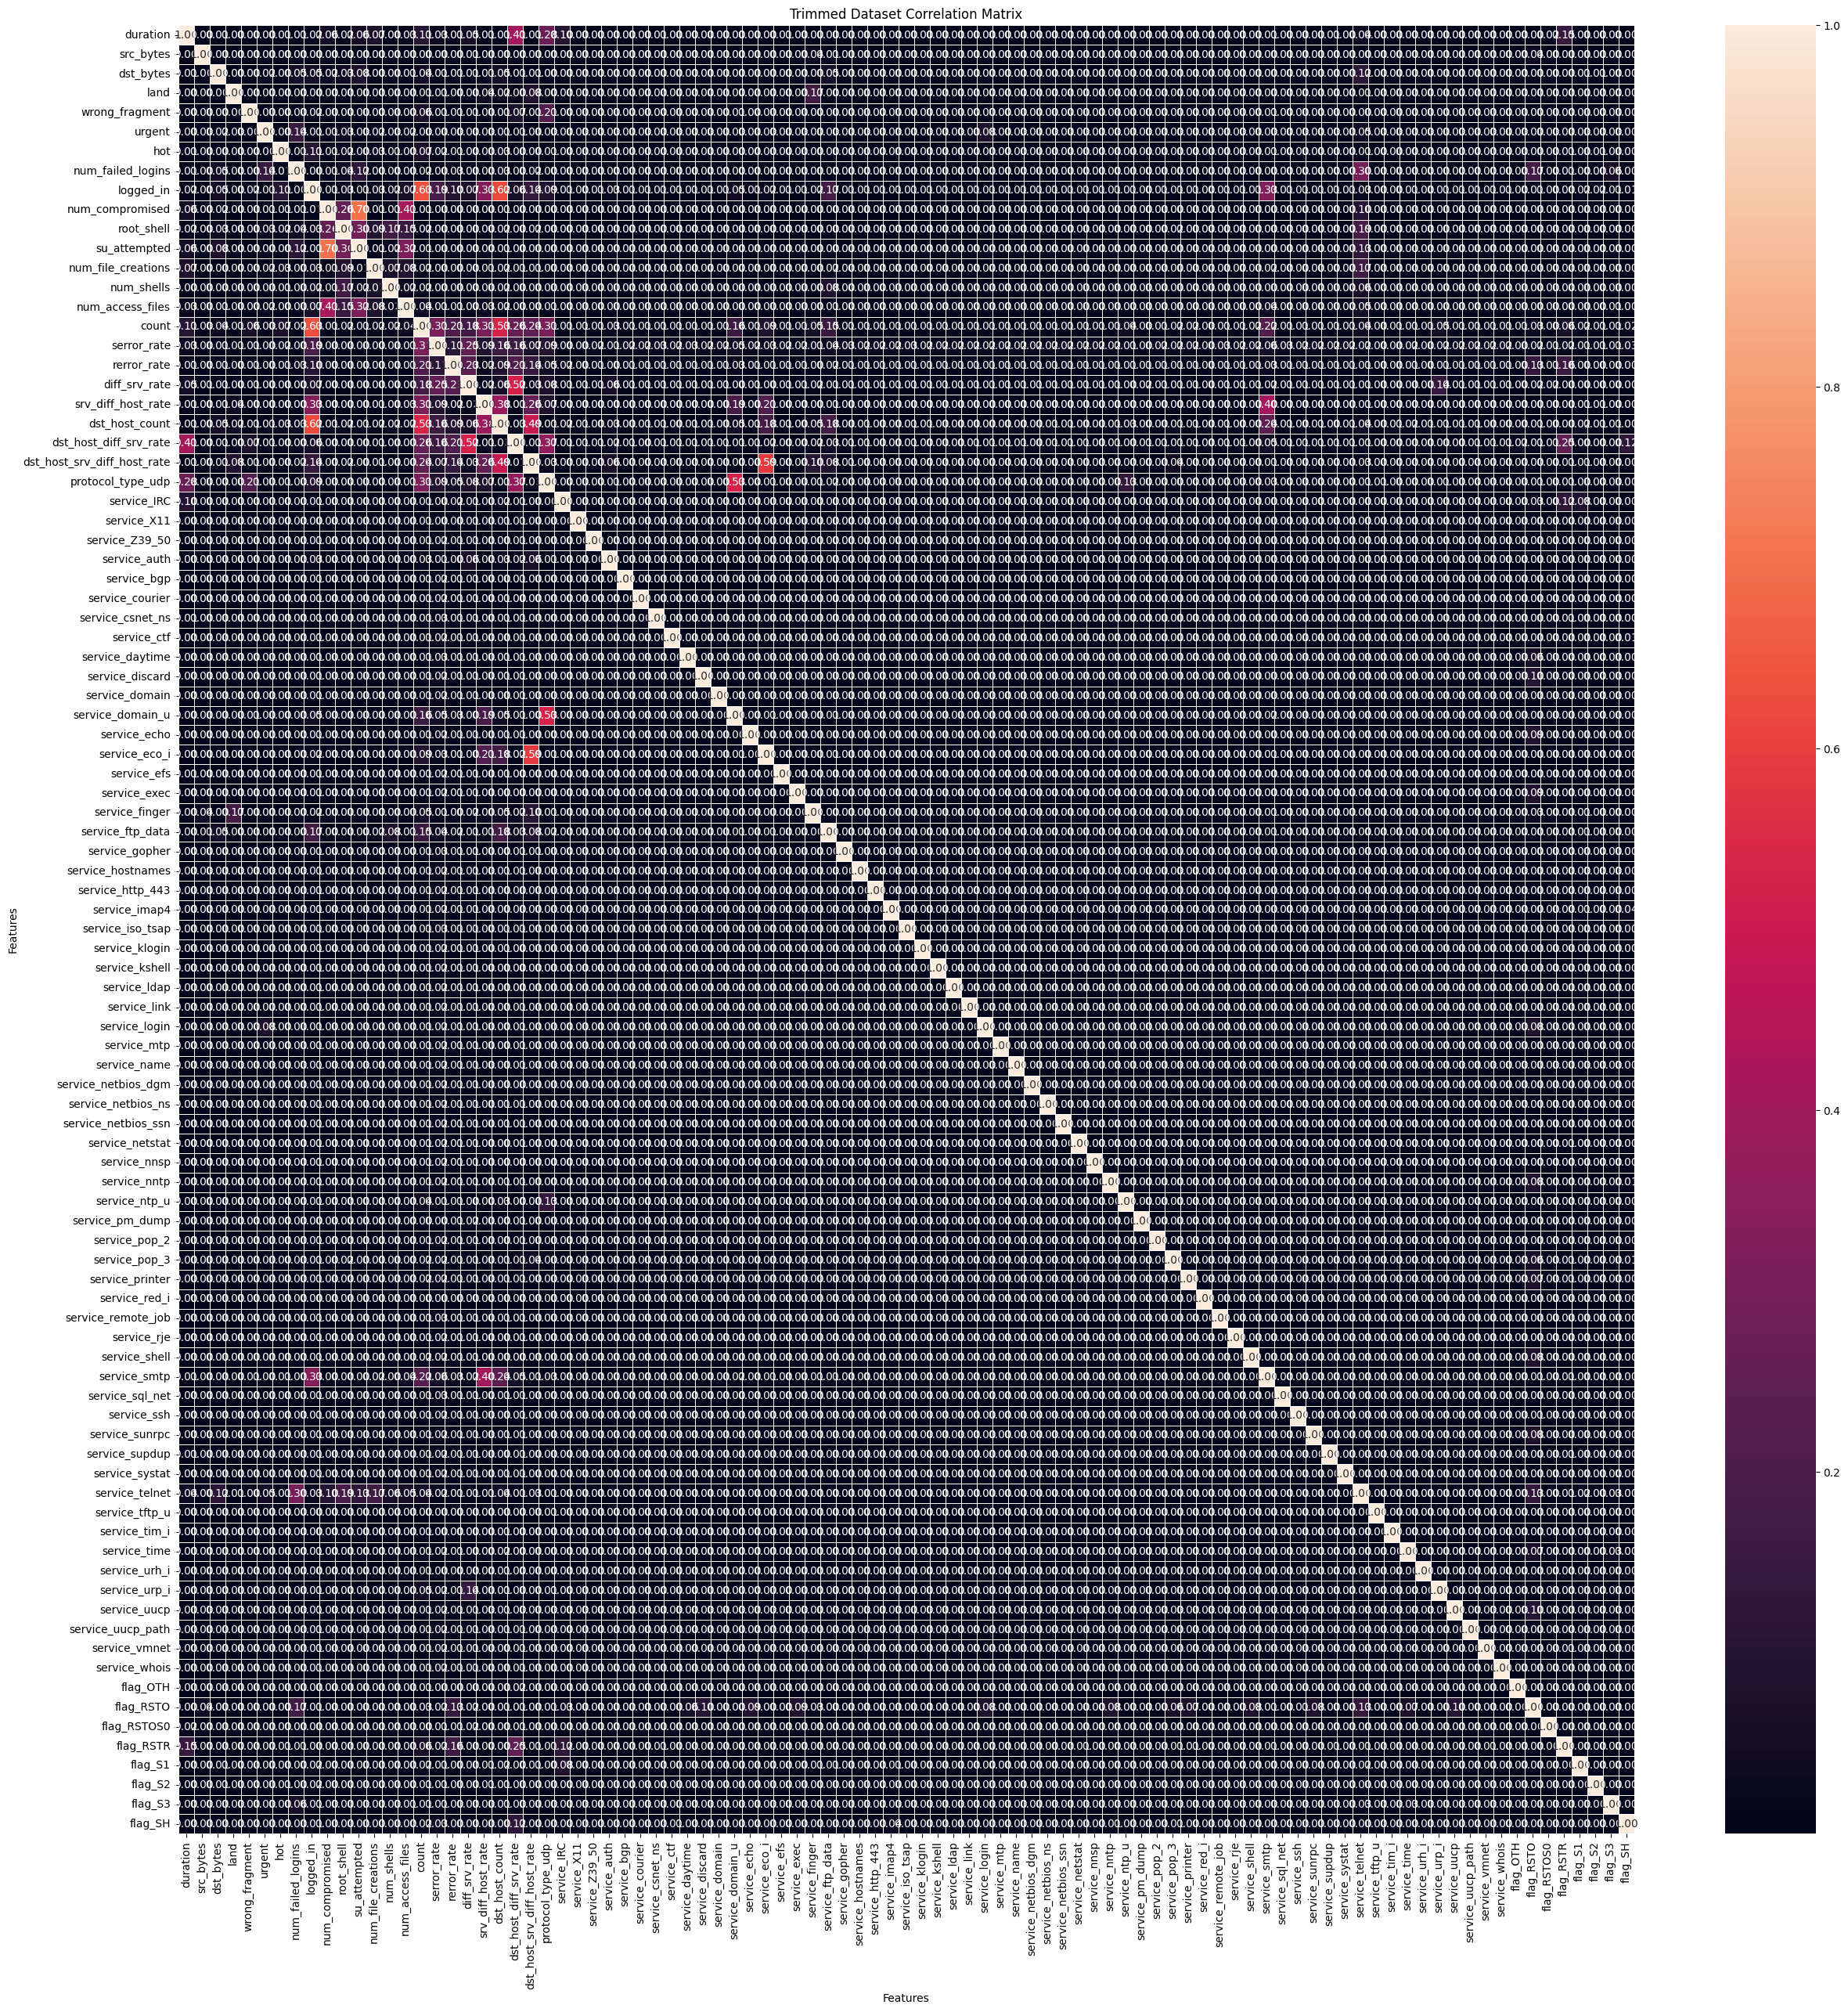

In [7]:
# Since the correlation matrix is symetrical, only look at one half
upperTriangle = corrMat.where(np.triu(np.ones(corrMat.shape), k=1).astype(bool))

# Drop features with high correlation above 0.8
xdf = xdf.drop([col for col in upperTriangle.columns if any(upperTriangle[col] > 0.8)], axis=1)

# Drop columns with only one unique value
xdf = xdf.drop(columns=[col for col in xdf.columns if xdf[col].nunique() == 1])

# Create and display correlation matrix
corrMat = xdf.corr().abs()

fig, axis = plt.subplots(figsize=(30, 30))
sns.heatmap(corrMat, annot=True, linewidths=.5, fmt='.2f', ax=axis)
plt.title("Trimmed Dataset Correlation Matrix") 
plt.xlabel("Features") 
plt.ylabel("Features")
plt.show()

The variables in the modified dataset are visualized to demonstrate the distribution of values for each feature.

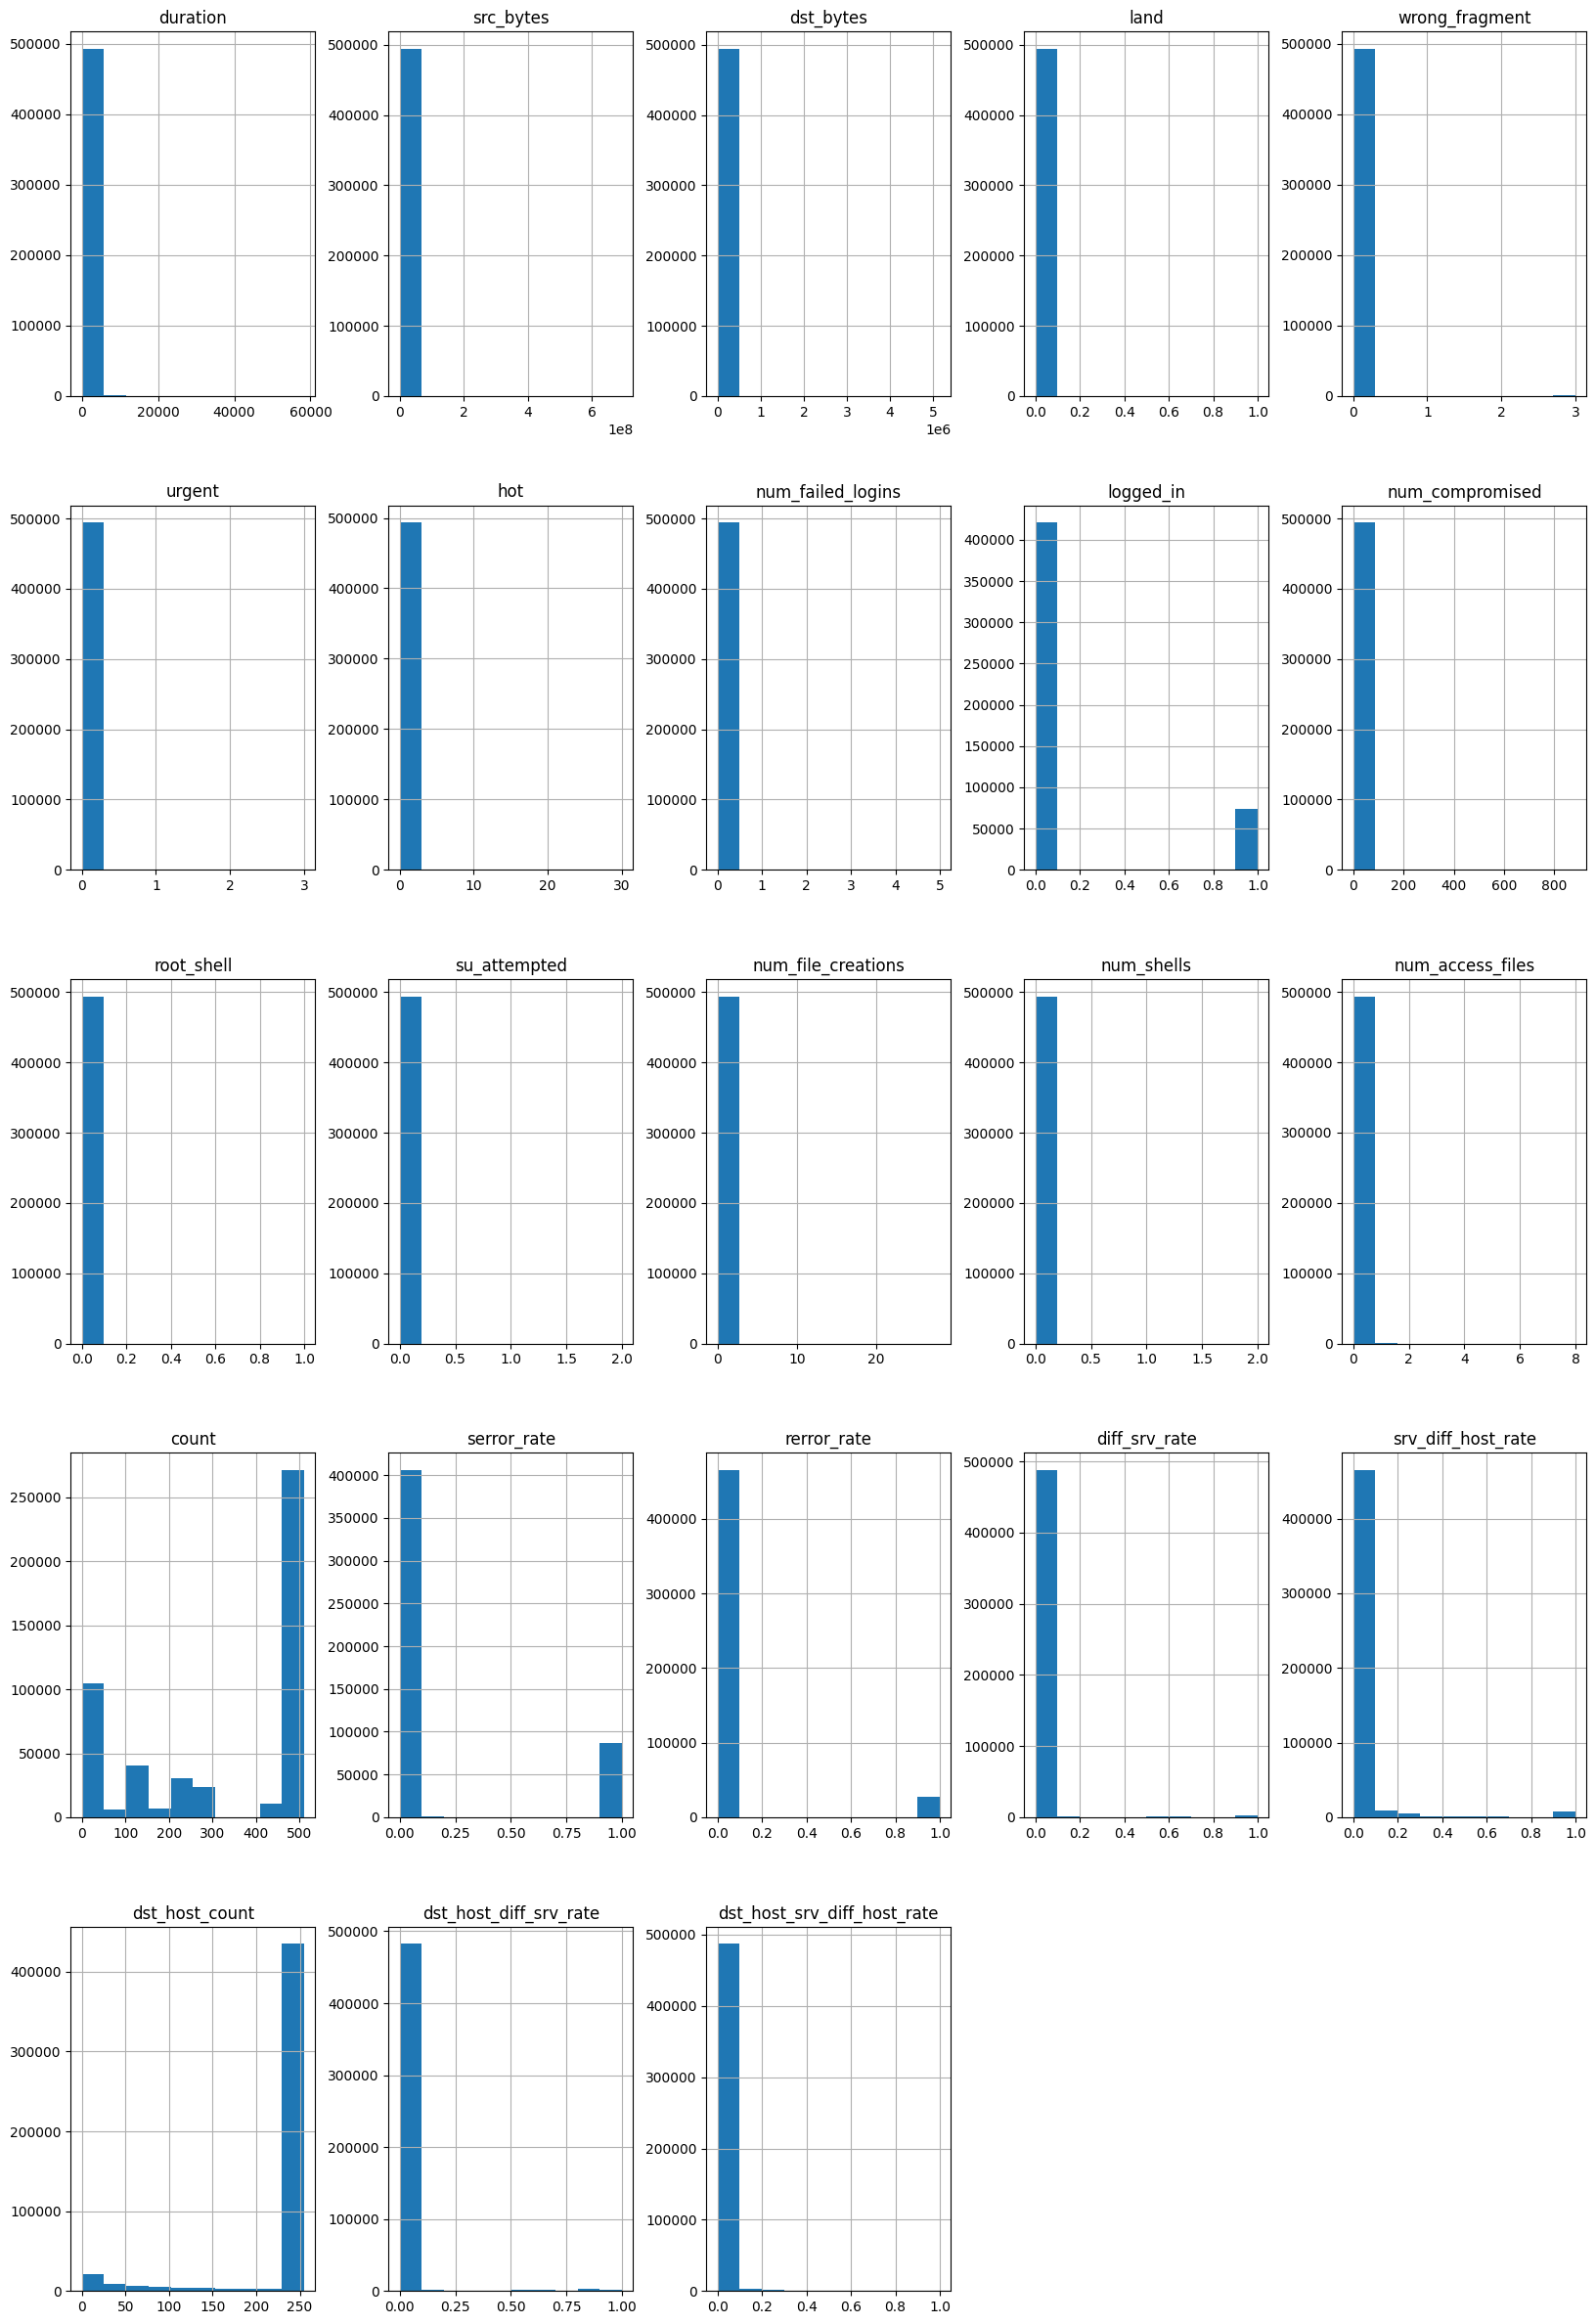

In [8]:
xdf.hist(figsize=(20, 30))
plt.show()

Prior to training, the dataset is scaled to enhance performance in weight selection and convergence.

In [9]:
from sklearn.preprocessing import StandardScaler

xArr = xdf.values
yArr = ydf.values

scaler = StandardScaler()
xArr = scaler.fit_transform(xArr)

*The performance metrics must be calculated manually. You may use “confusion_matrix” library to get TP, TN, FP, FN ONLY, then calculate the FPR, FNR, etc.… using the formulas from the slides.*  

**The professor has made the exception that both the Brier Score and the AUC can be calculated using a library**

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
# Add val to all to make variables instead of constants
def getMetrics(yTest, yPred, yProb):
    
    #Use Confusion Matrix to get TP, TN, FP, FN ONLY
    confMat = confusion_matrix(yTest, yPred, labels=[0,1])
    TPval, TNval, FPval, FNval = confMat[1][1], confMat[0][0], confMat[0][1], confMat[1][0]

    # Calculate performance metrics based on class slides
    Pval = TPval + FNval
    Nval = TNval + FPval

    TPRval = TPval / Pval
    TNRval = TNval / Nval
    FPRval = FPval / Nval
    FNRval = FNval / Pval

    r = TPval / Pval
    p = TPval / (TPval + FPval)

    #F1 can encounter 0 division error
    if p + r == 0:
        f1 = 0.0
    else:
        f1 = 2 * (p * r) / (p + r)

    Acc = (TPval + TNval) / (Pval + Nval)
    Err = (FPval + FNval) / (Pval + Nval)

    BACCval = (TPRval + TNRval) / 2
    TSSval = (TPval / (TPval + FNval)) - (FPval / (FPval+TNval))
    HSSval = (2 * (TPval * TNval - FPval * FNval)) / ((TPval + FNval) * (FNval + TNval) + (TPval + FPval) * (FPval + TNval))

    SPCval = TNval / (FPval + TNval)
    NPVval = TNval / (TNval + FNval)
    FDRval = FPval / (FPval + TPval)

    BSval = brier_score_loss(yTest, yProb)

    baseProb = np.mean(yTest)
    baseBSval = brier_score_loss(yTest, [baseProb]*len(yTest))
    BSSval = 1 - (BSval / baseBSval)

    AUCval = roc_auc_score(yTest, yProb)

    return [TPval, TNval, FPval, FNval, Pval, Nval, TPRval, TNRval, FPRval, FNRval, r, p, f1, Acc, Err, BACCval, TSSval, HSSval, SPCval, NPVval, FDRval, BSval, BSSval, AUCval]

*Implement 3 different classification algorithms in Python. One of them is Random Forest*  
In the below section, I have implemented the Random Forest Classifier using the Scikit-learn library.  

*The second one is from the deep learning list in the “Appendix → Additional Option: Deep Learning”*  
In the below section, I have selected and implemented the Convolutional 1D network using the Keras library.  

*The third is from the list of algorithms in “Appendix → Additional Option: Algorithms”*  
In the below section, I have selected the naive Bayes algorithm using the Scikit-learn library. This implementation comes as a result of previous attempts with an SVM taking multiple hours to train and being unable to complete training effectively.

*This is not from scratch implementation, just use the existing libraries to implement the algorithms*  

*In evaluating classification performance, students must use the 10-fold cross validation method. You must show the statistics as discussed in the “Evaluating Classifiers”
module to include all parameters that were introduced: TP, TF, FP, FN, TSS, HSS, etc... for each run of the 10-folds and also for overall as an average of all 10-folds execution.*  
The above defined getMetrics function I have written is used to calculate the statistics discussed in the "Evaluating Classifiers" module for each run of the 10 folds and also for the overall as an average of the 10 folds. Each of the three models identified are run on the same dataset.

*You must present experimental results that show the comparison of classification performance between the algorithms used in your project.*  
The experimental results for each of the three classification methods used in this project are captured in their respective data frames for comparison.

In [11]:
from sklearn.ensemble import RandomForestClassifier
import keras
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.naive_bayes import GaussianNB

#Create calculated metrics dataframes for storage
colNames = ["True Positve", "True Negative", "False Positive", "False Negative", "Positive", "Negative", "True Positive Rate", "True Negative Rate", "False Positive Rate", "False Negative Rate", "Recall/ Sensitivity", "Precision", "F1 Score", "Accuracy", "Error Rate", "Balanced Accuracy", "True Skill Statistics", "Heidke Skill Score", "Specificity", "Negative Predictive Value", "False Discovery Rate", "Brier Score", "Brier Skill Score", "Area Under ROC Curve"]
rfcMetrics = pd.DataFrame(columns=colNames)
convMetrics = pd.DataFrame(columns=colNames)
nbMetrics = pd.DataFrame(columns=colNames)

#Set index name for easier viewing
rfcMetrics.index.name = "Fold"
convMetrics.index.name = "Fold"
nbMetrics.index.name = "Fold"

#implement 10 k-fold with stratification
k = 10
foldLenNormal = attackIndex // k
foldLenAttack = (len(xArr) - attackIndex) // k
for fold in range(k):
    print("Fold {}".format(fold+1))
    #Determine test cases in fold
    if fold < k-1:
        testIndexesNormal = range(fold * foldLenNormal, (fold + 1) * foldLenNormal)
        testIndexesAttack = range(attackIndex + fold * foldLenAttack, attackIndex + (fold + 1) * foldLenAttack)
    else:
        testIndexesNormal = range(fold * foldLenNormal, attackIndex)
        testIndexesAttack = range(attackIndex + fold * foldLenAttack, len(xArr))

    print(testIndexesNormal)
    print(testIndexesAttack)

    #Split based on fold and stratify
    #This dramatically improves the performance of Naive Bayes
    xTest = np.concatenate((xArr[testIndexesNormal], xArr[testIndexesAttack]))
    xTrain = xArr[[i for i in range(len(xArr)) if i not in testIndexesNormal and i not in testIndexesAttack]]

    yTest = np.concatenate((yArr[testIndexesNormal], yArr[testIndexesAttack]))
    yTrain = yArr[[i for i in range(len(yArr)) if i not in testIndexesNormal and i not in testIndexesAttack]]

    #Join X and Y together to shuffle
    combinedTest = np.column_stack((xTest, yTest))
    combinedTrain = np.column_stack((xTrain, yTrain))

    #Shuffle
    np.random.seed(42)
    np.random.shuffle(combinedTest)
    np.random.shuffle(combinedTrain)

    #Split X and Y test data
    xTest = combinedTest[:, :-1]
    yTest = combinedTest[:, -1]

    #Split X and Y train data
    xTrain = combinedTrain[:, :-1]
    yTrain = combinedTrain[:, -1]

    yTest = yTest.astype(int)
    yTrain = yTrain.astype(int)

    #Reshape to work with Conv 1D network
    xTrainSteps = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
    xTestSteps = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

    #Create and test each model

    #Random Forest
    rfcModel = RandomForestClassifier(n_estimators = 100, random_state=42)
    rfcModel.fit(xTrain, yTrain)

    #Convolutional 1D Network
    convModel = keras.models.Sequential()
    convModel.add(Conv1D(filters=32, kernel_size=1, activation="relu"))
    convModel.add(MaxPooling1D(pool_size=1))
    convModel.add(Conv1D(filters=64, kernel_size=1, activation="relu"))
    convModel.add(MaxPooling1D(pool_size=1))
    convModel.add(Flatten())
    convModel.add(Dense(64, activation="relu"))
    convModel.add(Dense(1, activation="sigmoid"))
    convModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    convModel.fit(xTrainSteps, yTrain, epochs=10, batch_size=32, validation_split=0.1)

    #Naive Bayes
    nbModel = GaussianNB()
    nbModel.fit(xTrain, yTrain)

    #Use Confusion Matrix to get TP, TN, FP, FN ONLY
    #Store results in dataframes
    rfcMetrics.loc[len(rfcMetrics.index)] = getMetrics(yTest, rfcModel.predict(xTest), rfcModel.predict_proba(xTest)[:, 1])
    convMetrics.loc[len(convMetrics.index)] = getMetrics(yTest, (convModel.predict(xTestSteps) >= 0.5).astype(int), convModel.predict(xTestSteps))
    nbMetrics.loc[len(nbMetrics.index)] = getMetrics(yTest, nbModel.predict(xTest), nbModel.predict_proba(xTest)[:, 1])

2024-11-01 11:47:13.408058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 1
range(0, 9727)
range(97278, 136952)
Epoch 1/10
12505/12505 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9949 - loss: 0.0276 - val_accuracy: 0.9989 - val_loss: 0.0046
Epoch 2/10
12505/12505 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9987 - loss: 0.0046 - val_accuracy: 0.9991 - val_loss: 0.0034
Epoch 3/10
12505/12505 ━━━━━━━━━━━━━━━━━━━━ 12s 994us/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9990 - val_loss: 0.0037
Epoch 4/10
12505/12505 ━━━━━━━━━━━━━━━━━━━━ 12s 943us/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.9993 - val_loss: 0.0032
Epoch 5/10
12505/12505 ━━━━━━━━━━━━━━━━━━━━ 11s 916us/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 6/10
12505/12505 ━━━━━━━━━━━━━━━━━━━━ 11s 913us/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9994 - val_loss: 0.0039
Epoch 7/10
12505/12505 ━━━━━━━━━━━━━━━━━━━━ 11s 912us/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9993 - val_loss: 0.0069
Epoch 8/10
12505

*You must show the statistics as discussed in the “Evaluating Classifiers” module to include all parameters that were introduced for each run of the 10-folds and also for overall as an average of all 10-folds execution*  
The statistics calculated have been stored in the data frames for each fold and respective model, and the average for each is now calculated.

In [12]:
#calculate average metrics from k-fold
rfcMetrics.loc["Average"] =  rfcMetrics.mean()
convMetrics.loc["Average"] =  convMetrics.mean()
nbMetrics.loc["Average"] =  nbMetrics.mean()

The counts of positive and negative identifications should be whole numbers represented as integers, and are updated as such in the section below.

In [13]:
#convert whole numbers back to ints
intCols = ["True Positve", "True Negative", "False Positive", "False Negative", "Positive", "Negative"]
rfcMetrics[intCols] = rfcMetrics[intCols].astype(int)
convMetrics[intCols] = convMetrics[intCols].astype(int)
nbMetrics[intCols] = nbMetrics[intCols].astype(int)

*Provide the result of the metrics in tabular format listing all details for easier visualization (for each fold and average). Your Jupyter Notebook should also show the result in tabular format.*  
The three sections below display the results of the metrics in a tabular format listing all details for each fold and the average for each model.

The below section provides a tabular view of the metrics from the Random Forest Classifier.

In [14]:
#Display random forest classifier performance metrics
from IPython.display import display

#Set display options to prevent truncation
pd.set_option('display.max_columns', None)  #Show all columns
pd.set_option('display.expand_frame_repr', False)  #Prevent line-wrapping

display(rfcMetrics)

,True Positve,True Negative,False Positive,False Negative,Positive,Negative,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Recall/ Sensitivity,Precision,F1 Score,Accuracy,Error Rate,Balanced Accuracy,True Skill Statistics,Heidke Skill Score,Specificity,Negative Predictive Value,False Discovery Rate,Brier Score,Brier Skill Score,Area Under ROC Curve
Fold,,,,,,,,,,,,,,,,,,,,,,,,
0,39617,9724,3,57,39674,9727,0.998563,0.999692,0.000308,0.001437,0.998563,0.999924,0.999243,0.998785,0.001215,0.999127,0.998255,0.996168,0.999692,0.994172,0.000076,0.001476,0.990669,0.999996
1,39674,9723,4,0,39674,9727,1.000000,0.999589,0.000411,0.000000,1.000000,0.999899,0.999950,0.999919,0.000081,0.999794,0.999589,0.999744,0.999589,1.000000,0.000101,0.000100,0.999368,1.000000
2,39670,9727,0,4,39674,9727,0.999899,1.000000,0.000000,0.000101,0.999899,1.000000,0.999950,0.999919,0.000081,0.999950,0.999899,0.999744,1.000000,0.999589,0.000000,0.000131,0.999170,1.000000
3,39660,9723,4,14,39674,9727,0.999647,0.999589,0.000411,0.000353,0.999647,0.999899,0.999773,0.999636,0.000364,0.999618,0.999236,0.998848,0.999589,0.998562,0.000101,0.000437,0.997234,0.999999
4,39462,9726,1,212,39674,9727,0.994656,0.999897,0.000103,0.005344,0.994656,0.999975,0.997308,0.995688,0.004312,0.997277,0.994554,0.986477,0.999897,0.978668,0.000025,0.003070,0.980586,0.999950
5,39560,9721,6,114,39674,9727,0.997127,0.999383,0.000617,0.002873,0.997127,0.999848,0.998486,0.997571,0.002429,0.998255,0.996510,0.992351,0.999383,0.988409,0.000152,0.001607,0.989836,0.999992
6,39590,9725,2,84,39674,9727,0.997883,0.999794,0.000206,0.002117,0.997883,0.999949,0.998915,0.998259,0.001741,0.998839,0.997677,0.994513,0.999794,0.991436,0.000051,0.002913,0.981578,0.999749
7,39665,9726,1,9,39674,9727,0.999773,0.999897,0.000103,0.000227,0.999773,0.999975,0.999874,0.999798,0.000202,0.999835,0.999670,0.999360,0.999897,0.999076,0.000025,0.000133,0.999158,1.000000
8,39674,9725,2,0,39674,9727,1.000000,0.999794,0.000206,0.000000,1.000000,0.999950,0.999975,0.999960,0.000040,0.999897,0.999794,0.999872,0.999794,1.000000,0.000050,0.000021,0.999867,1.000000


The below section provides a tabular view of the metrics from the Convolutional 1D network.

In [15]:
#Display convolutional 1D network classifier performance metrics
display(convMetrics)

,True Positve,True Negative,False Positive,False Negative,Positive,Negative,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Recall/ Sensitivity,Precision,F1 Score,Accuracy,Error Rate,Balanced Accuracy,True Skill Statistics,Heidke Skill Score,Specificity,Negative Predictive Value,False Discovery Rate,Brier Score,Brier Skill Score,Area Under ROC Curve
Fold,,,,,,,,,,,,,,,,,,,,,,,,
0,39605,9696,31,69,39674,9727,0.998261,0.996813,0.003187,0.001739,0.998261,0.999218,0.998739,0.997976,0.002024,0.997537,0.995074,0.993609,0.996813,0.992934,0.000782,0.001193,0.992459,0.999948
1,39674,9710,17,0,39674,9727,1.000000,0.998252,0.001748,0.000000,1.000000,0.999572,0.999786,0.999656,0.000344,0.999126,0.998252,0.998911,0.998252,1.000000,0.000428,0.000328,0.997927,0.999846
2,39668,9698,29,6,39674,9727,0.999849,0.997019,0.002981,0.000151,0.999849,0.999269,0.999559,0.999292,0.000708,0.998434,0.996867,0.997758,0.997019,0.999382,0.000731,0.000720,0.995449,0.999858
3,39570,9705,22,104,39674,9727,0.997379,0.997738,0.002262,0.002621,0.997379,0.999444,0.998410,0.997449,0.002551,0.997558,0.995117,0.991961,0.997738,0.989397,0.000556,0.002141,0.986463,0.999971
4,39194,9722,5,480,39674,9727,0.987901,0.999486,0.000514,0.012099,0.987901,0.999872,0.993851,0.990182,0.009818,0.993694,0.987387,0.969519,0.999486,0.952950,0.000128,0.008052,0.949080,0.997608
5,39490,9710,17,184,39674,9727,0.995362,0.998252,0.001748,0.004638,0.995362,0.999570,0.997462,0.995931,0.004069,0.996807,0.993614,0.987218,0.998252,0.981403,0.000430,0.003644,0.976953,0.998407
6,38163,9709,18,1511,39674,9727,0.961915,0.998149,0.001851,0.038085,0.961915,0.999529,0.980361,0.969049,0.030951,0.980032,0.960064,0.907494,0.998149,0.865330,0.000471,0.028141,0.822041,0.998117
7,39647,9726,1,27,39674,9727,0.999319,0.999897,0.000103,0.000681,0.999319,0.999975,0.999647,0.999433,0.000567,0.999608,0.999217,0.998210,0.999897,0.997232,0.000025,0.000778,0.995079,0.999924
8,39674,9721,6,0,39674,9727,1.000000,0.999383,0.000617,0.000000,1.000000,0.999849,0.999924,0.999879,0.000121,0.999692,0.999383,0.999616,0.999383,1.000000,0.000151,0.000082,0.999483,1.000000


The below section provides a tabular view of the metrics from the naive Bayes algorithm.

In [16]:
#Display naive bayes performance metrics
display(nbMetrics)

,True Positve,True Negative,False Positive,False Negative,Positive,Negative,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Recall/ Sensitivity,Precision,F1 Score,Accuracy,Error Rate,Balanced Accuracy,True Skill Statistics,Heidke Skill Score,Specificity,Negative Predictive Value,False Discovery Rate,Brier Score,Brier Skill Score,Area Under ROC Curve
Fold,,,,,,,,,,,,,,,,,,,,,,,,
0,38800,9724,3,874,39674,9727,0.977970,0.999692,0.000308,0.022030,0.977970,0.999923,0.988825,0.982247,0.017753,0.988831,0.977662,0.945702,0.999692,0.917532,0.000077,0.017753,0.887731,0.987234
1,39674,9715,12,0,39674,9727,1.000000,0.998766,0.001234,0.000000,1.000000,0.999698,0.999849,0.999757,0.000243,0.999383,0.998766,0.999232,0.998766,1.000000,0.000302,0.000243,0.998464,0.998766
2,33210,9721,6,6464,39674,9727,0.837072,0.999383,0.000617,0.162928,0.837072,0.999819,0.911236,0.869031,0.130969,0.918228,0.836455,0.668857,0.999383,0.600618,0.000181,0.133428,0.156213,0.997502
3,19166,9722,5,20508,39674,9727,0.483087,0.999486,0.000514,0.516913,0.483087,0.999739,0.651406,0.584765,0.415235,0.741287,0.482573,0.268764,0.999486,0.321601,0.000261,0.413286,-1.613590,0.992950
4,28578,9723,4,11096,39674,9727,0.720321,0.999589,0.000411,0.279679,0.720321,0.999860,0.837377,0.775308,0.224692,0.859955,0.719909,0.503301,0.999589,0.467025,0.000140,0.224146,-0.417482,0.981681
5,11879,9719,8,27795,39674,9727,0.299415,0.999178,0.000822,0.700585,0.299415,0.999327,0.460775,0.437198,0.562802,0.649296,0.298593,0.143682,0.999178,0.259077,0.000673,0.562802,-2.559119,0.988764
6,36879,9720,7,2795,39674,9727,0.929551,0.999280,0.000720,0.070449,0.929551,0.999810,0.963401,0.943281,0.056719,0.964416,0.928831,0.838162,0.999280,0.776668,0.000190,0.056719,0.641310,0.945309
7,38873,9724,3,801,39674,9727,0.979810,0.999692,0.000308,0.020190,0.979810,0.999923,0.989764,0.983725,0.016275,0.989751,0.979502,0.950085,0.999692,0.923895,0.000077,0.016270,0.897112,0.993420
8,1,9727,0,39673,39674,9727,0.000025,1.000000,0.000000,0.999975,0.000025,1.000000,0.000050,0.196919,0.803081,0.500013,0.000025,0.000010,1.000000,0.196903,0.000000,0.799309,-4.054769,1.000000


*Provide a discussion about your results. Which algorithm performs better and why? Justify your answer.*  
The code below identifies the best performance metrics and the model from which these results originated. Some metrics are optimized by selecting the maximum score, and others are optimized by selecting the minimum score. The results for all metrics are displayed for easy evaluation of the best models. A discussion of the models and results is also provided below.

In [17]:
maxList = ["True Positive Rate", "True Negative Rate", "Recall/ Sensitivity", "Precision", "F1 Score", "Accuracy", "Balanced Accuracy", "True Skill Statistics", "Heidke Skill Score", "Specificity", "Negative Predictive Value", "Brier Skill Score", "Area Under ROC Curve"]

for col in colNames:
    if col in maxList:
        mVal = max(rfcMetrics.loc["Average", col], convMetrics.loc["Average", col], nbMetrics.loc["Average", col])
    else:
        mVal = min(rfcMetrics.loc["Average", col], convMetrics.loc["Average", col], nbMetrics.loc["Average", col])

    #Determine the model with the best value
    if mVal == rfcMetrics.loc["Average", col]:
        mModel = "Random Forest Classifier"
    elif mVal == convMetrics.loc["Average", col]:
        mModel = "1D Convolutional Network"
    elif mVal == nbMetrics.loc["Average", col]:
        mModel = "Naive Bayes Algorithm"
    else:
        mModel = "NOT FOUND"

    print("Best {}: {} = {}".format(col, mModel, mVal))

Best True Positve: Naive Bayes Algorithm = 24706
Best True Negative: 1D Convolutional Network = 9711
Best False Positive: Random Forest Classifier = 2
Best False Negative: Random Forest Classifier = 49
Best Positive: Random Forest Classifier = 39674
Best Negative: Random Forest Classifier = 9727
Best True Positive Rate: Random Forest Classifier = 0.9987548520441599
Best True Negative Rate: Random Forest Classifier = 0.9997327281312973
Best False Positive Rate: Random Forest Classifier = 0.00026727186870279755
Best False Negative Rate: Random Forest Classifier = 0.0012451479558400968
Best Recall/ Sensitivity: Random Forest Classifier = 0.9987548520441599
Best Precision: Random Forest Classifier = 0.9999343897564226
Best F1 Score: Random Forest Classifier = 0.9993435698682251
Best Accuracy: Random Forest Classifier = 0.9989473910808566
Best Error Rate: Random Forest Classifier = 0.0010526089191434129
Best Balanced Accuracy: Random Forest Classifier = 0.9992437900877282
Best True Skill St

Based on the average results from the 10-fold cross validation testing, it is clear that the Random Forest Classifier stands out as the best algorithm due to its superior performance. The Random Forest Classifier was able to achieve the highest true positive rate, true negative rate, recall/sensitivity, precision, F1 score, accuracy, balanced accuracy, true skill statistics, Heidke skill score, specificity, negative predictive value, Brier skill score, and area under the ROC curve. The Random Forest Classifier was also able to achieve the lowest false positive rate, false negative rate, error rate, and Brier score. Based on these metrics, the Random Forest Classifier was able to outperform both the Convolutional 1D network and the naive Bayes algorithm in all categories. Within these categories, the precision, recall, F1 score, and balanced accuracy stand out by offering deeper insights into the strength of the model. The Random Forest Classifier achieved a precision of 99.9%, a recall of 99.8%, an F1 score of 99.9%, and a balanced accuracy of 99.9%. The precision of the model indicates its ability to accurately predict positive results. With this dataset, this means that fewer false positives will be generated, and thus network administrators would be more well-equipped to respond effectively and take the detected attacks seriously. If the precision were too low, network administrators may not respond with urgency to the attacks because of a high likelihood that it is a false alarm. The recall of the model indicates its ability to identify attacks and not miss threats to the network. Since the cost of missing an attack could be high, the recall gives valuable insight into the ability of the model to accurately detect if an attack is occurring within the network. The F1 score is the harmonic mean of precision and recall and provides an effective way to determine if the model is a good fit when both false positives and false negatives have a high cost. In this scenario, false positives cause network administrators to become overburdened with false alerts, resulting in a loss in ability to respond to real threats and a decreased trust in the system. False negatives have a high cost as well, making the network susceptible to exploitation and leaving critical resources vulnerable to attack. The F1 score provides valuable insight into the ability of the model to perform while both of these concerns are present. The balanced accuracy provides information about the model's ability to correctly classify data into normal and attack traffic. While the accuracy of this model is also high, the balanced accuracy provides a better understanding of the accuracy because an imbalance in the classes exists within the data, which the balanced accuracy can adjust for. The balanced accuracy of this model shows that the Random Forest Classifier is able to correctly identify attacks in the overwhelming majority of cases. These four metrics can provide a good measure of the model's performance, and help to demonstrate why the Random Forest Classifier is the best choice of the three models evaluated.  
While the Random Forest Classifier performed the best, the Convolutional 1D network also performed incredibly well. For most metrics, the performance of the Random Forest Classifier and the Convolutional 1D network was within less than 1% difference. The Convolutional 1D network achieved a similar precision of 99.9%, a recall of 99.3%, an F1 score of 99.6%, and a balanced accuracy of 99.5%. With this dataset and the current hyperparameters for these models, the Random Forest Classifier was able to perform slightly better, but it is possible that both of these models could perform well predicting additional data from this network. Further evaluation could be done to test how well each model can generalize to the larger population, and hyperparameter optimization could enable either of these models to improve performance. These models both performed well due to the extensive features present within the data and their ability to detect complex patterns. The Random Forest Classifier and the Convolutional 1D network could be used together within the network to produce a more robust attack detection system.  
The naive Bayes algorithm performed comparatively worse than the other two models, with a precision of 89%, a recall of 62%, an F1 score of 68%, and a balanced accuracy of only 81%. This model exhibited a significantly faster training and prediction time as compared to the other two models, but struggled with certain folds of the data. This could be caused in part by the assumption that all features are independent, which is not necessarily true with this dataset. While the correlation of the data was minimized, some network conditions could be dependent on each other. The naive Bayes model likely struggles to understand the complex patterns within the dataset due to this assumption of conditional independence.